Импорт нужных модулей.

In [42]:
from google.colab import drive
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential, Model
import numpy as np
import pandas as pd
import os
import tensorflow.keras.backend as K
from sklearn.metrics import *
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pickle
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [43]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Анализ датасета.
Для этого, в основном, будут использоваться инструменты pandas dataframe. А также библиотек sklearn и seaborn.

===========================================================

Dataset Analysis
Main tool is pandas dataframe, sklearn and seaborn as instrument for nice heatmap.

In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Загрузка датасета по частям с дальнейшей конкатенацией. 
df1=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")#,nrows = 50000
df2=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df3=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df4=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Monday-WorkingHours.pcap_ISCX.csv")
df5=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df6=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df7=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Tuesday-WorkingHours.pcap_ISCX.csv")
df8=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Wednesday-workingHours.pcap_ISCX.csv")

#Вывод уникальных признаков типов аттак или benign для каждого датасета. Ожидается DDoS, DoS Types и т.д.
print (df1[' Label'].unique())
print (df2[' Label'].unique())
print (df3[' Label'].unique())
print (df4[' Label'].unique())
print (df5[' Label'].unique())
print (df6[' Label'].unique())
print (df7[' Label'].unique())
print (df8[' Label'].unique(), "\n")

#Конкатенация и общая информация о наборе данных
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df= pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8
data = df.copy() #Датафрейм копируем в дату для дальнейших операций
data.info()



['BENIGN' 'DDoS']
['BENIGN' 'PortScan']
['BENIGN' 'Bot']
['BENIGN']
['BENIGN' 'Infiltration']
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
['BENIGN' 'FTP-Patator' 'SSH-Patator']
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Len

<h4>Необязательный шаг.</h4>

Тепловая карта для сырого датасета. Благодаря ней можно понять основные недостатки сырого датасета и с ними работать в дальнейшем препроцессинге.

In [45]:
#fig= plt.figure(figsize=(70,70))
#sns.heatmap(data.corr(), annot=True)

Необходимо отбросить пустые значения из изначального датасета.

In [46]:
#Подтягиваем из датасета колонки с NaN и создаем из них массив deleteCol. Получившийся массив "вычитаем" из дата.
deleteCol = []
for column in data.columns:
    if data[column].isnull().values.any():
        deleteCol.append(column)
for column in deleteCol:
    data.drop([column],axis=1,inplace=True)


Аналогично поступаем с элементами numpy.object

In [47]:
deleteCol = []
for column in data.columns:
    if column == ' Label':
        continue
    elif data[column].dtype==np.object:
        deleteCol.append(column)
for column in deleteCol:
    data.drop(column,axis=1,inplace=True)


Выявим уникальные значения метрики Flow Duration

In [48]:
data[' Flow Duration'].unique()

array([       3,      109,       52, ..., 11509095, 11512230,  1048635])

Привидем каждый столбец к единому числовому типу на основе максимального значения в выбранном столбце.

In [49]:
#int8   от отрицательного -128 до положительного 127
#int16  от отрицательного -32768 до положительных 32767
#int32  от отрицательного 2 147 483 648 до положительного 2 147 483 647

for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
#Проверим типы данных
data.info()
#Проверим количество маркированных пакетов
print(data[" Label"].value_counts(), "\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 78 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int32  
 1    Flow Duration                int32  
 2    Total Fwd Packets            int32  
 3    Total Backward Packets       int32  
 4   Total Length of Fwd Packets   int32  
 5    Total Length of Bwd Packets  int32  
 6    Fwd Packet Length Max        int16  
 7    Fwd Packet Length Min        int16  
 8    Fwd Packet Length Mean       float32
 9    Fwd Packet Length Std        float32
 10  Bwd Packet Length Max         int16  
 11   Bwd Packet Length Min        int16  
 12   Bwd Packet Length Mean       float32
 13   Bwd Packet Length Std        float32
 14   Flow Packets/s               float32
 15   Flow IAT Mean                float32
 16   Flow IAT Std                 float32
 17   Flow IAT Max                 int32  
 18   Flow IAT Min          

Подчистим датасет от пустых и бесконечных значений.

In [50]:
# Проверим количество потерянных значений в датасете
print(f"Missing values: {data.isnull().sum().sum()}", "\n")
#Проверим датасет на бесконечные значения. Заменим их на NaN, так как их потом просто удалить.
data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Missing values: {data.isnull().sum().sum()}", "\n")


Missing values: 0 

Missing values: 2867 



Ключевая проверка датасета на кол-во маркированных пакетов для последующего семплирования.

In [51]:
print(data[' Label'].value_counts(), "\n")

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64 



<h2>Семплирование</h2>
Процедура предназначена для проведения качественного обучения НС в заданных соотношениях. То есть, мы исключим ситуацию, где из 100 элементов 95% - одного типа. 

По дефолту оставил 0.5, т.е. из всех оставшихся строк, маркированных как, допустим, "Heartbleed", будут выбраны 50%. В дальнейшем удобно корректтировать их семплирование, благодаря громоздкому реплицированному коду.

In [52]:
#Bot = data[data[' Label'] == 'Bot'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Bot']
#data = pd.concat([attack, Bot])
#print(data[' Label'].value_counts(), "\n")

#Infiltration = data[data[' Label'] == 'Infiltration'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Infiltration']
#data = pd.concat([attack, Infiltration])
#print(data[' Label'].value_counts(), "\n")

#BF = data[data[' Label'] == 'Web Attack � Brute Force'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � Brute Force']
#data = pd.concat([attack, BF])
#print(data[' Label'].value_counts(), "\n")

#XSS = data[data[' Label'] == 'Web Attack � XSS'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � XSS']
#data = pd.concat([attack, XSS])
#print(data[' Label'].value_counts(), "\n")

#SQLI = data[data[' Label'] == 'Web Attack � Sql Injection'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � Sql Injection']
#data = pd.concat([attack, SQLI])
#print(data[' Label'].value_counts(), "\n")

#FTPP = data[data[' Label'] == 'FTP-Patator'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'FTP-Patator']
#data = pd.concat([attack, FTPP])
#print(data[' Label'].value_counts(), "\n")

#SSHP = data[data[' Label'] == 'SSH-Patator'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'SSH-Patator']
#data = pd.concat([attack, SSHP])
#print(data[' Label'].value_counts(), "\n")

#DOSs = data[data[' Label'] == 'DoS slowloris'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS slowloris']
#data = pd.concat([attack, DOSs])
#print(data[' Label'].value_counts(), "\n")

#DOShttp = data[data[' Label'] == 'DoS Slowhttptest'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS Slowhttptest']
#data = pd.concat([attack, DOShttp])
#print(data[' Label'].value_counts(), "\n")



#GY = data[data[' Label'] == 'DoS GoldenEye'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS GoldenEye']
#data = pd.concat([attack, GY])
#print(data[' Label'].value_counts(), "\n")

#HB = data[data[' Label'] == 'Heartbleed'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Heartbleed']
#data = pd.concat([attack, HB])

In [53]:
benign = data[data[' Label'] == 'BENIGN'].sample(frac=0.006).reset_index(drop=True)
attack = data[data[' Label'] != 'BENIGN']
data = pd.concat([attack, benign])
#print(data[' Label'].value_counts(), "\n")

ddos = data[data[' Label'] == 'DDoS'].sample(frac=0.08).reset_index(drop=True)
attack = data[data[' Label'] != 'DDoS']
data = pd.concat([attack, ddos])
#print(data[' Label'].value_counts(), "\n")

PortScan = data[data[' Label'] == 'PortScan'].sample(frac=0.06).reset_index(drop=True)
attack = data[data[' Label'] != 'PortScan']
data = pd.concat([attack, PortScan])
#print(data[' Label'].value_counts(), "\n")

Hulk = data[data[' Label'] == 'DoS Hulk'].sample(frac=0.04).reset_index(drop=True)
attack = data[data[' Label'] != 'DoS Hulk']
data = pd.concat([attack, Hulk])
#print(data[' Label'].value_counts(), "\n")

#посчитаем еще раз количества маркированных итемов. По ней можно судить о корректности семплирования.
print(data[' Label'].value_counts(), "\n")


BENIGN                        13639
DoS GoldenEye                 10293
DDoS                          10242
PortScan                       9536
DoS Hulk                       9243
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
Heartbleed                       11
Name:  Label, dtype: int64 



После семплирования запишем в y - весь датасет, а без лейбла в Х. Для дальнейшего применения в выборе признаков

In [54]:
y = data[' Label']
X = data.drop([' Label'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82276 entries, 24072 to 9242
Data columns (total 77 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Destination Port             82276 non-null  int32  
 1    Flow Duration                82276 non-null  int32  
 2    Total Fwd Packets            82276 non-null  int32  
 3    Total Backward Packets       82276 non-null  int32  
 4   Total Length of Fwd Packets   82276 non-null  int32  
 5    Total Length of Bwd Packets  82276 non-null  int32  
 6    Fwd Packet Length Max        82276 non-null  int16  
 7    Fwd Packet Length Min        82276 non-null  int16  
 8    Fwd Packet Length Mean       82276 non-null  float32
 9    Fwd Packet Length Std        82276 non-null  float32
 10  Bwd Packet Length Max         82276 non-null  int16  
 11   Bwd Packet Length Min        82276 non-null  int16  
 12   Bwd Packet Length Mean       82276 non-null  float32
 13

Обязательная проверка полученного датасета на наличие NaN и бесконечностей. 

Ожидается: False False 

In [55]:
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))

True
False


Замена NaN на нули. .fillna предоставляет возможность поменять NaN на значение или на результат функции.

Запускать только при boolean = True np.isnan(x)

In [56]:
print(np.where(np.isnan(X)))
X = pd.DataFrame(X).fillna(0)
print(np.where(np.isnan(X)))
X.info()

(array([   37,   129,   585,   680,   693,   705,   737,   812,  1003,
        1221,  6684, 11200, 11450, 40449, 40661, 41964, 43227, 43871,
       48388, 50089, 52001, 64427, 65417, 67758, 67789, 68598, 69106,
       71276, 71422, 72531, 73325, 73506, 73745, 73875, 74153, 74236,
       75270, 75485, 75596, 75737, 76354, 76629, 76750, 77198, 77315,
       77378, 77439, 77486, 78104, 78166, 78231, 78352, 78911, 79538,
       79578, 79811, 80408, 80563, 81043, 81196, 81844, 81981, 82231,
       82251, 82269]), array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]))
(array([], dtype=int64), array([], dtype=int64))
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82276 entries, 24072 to 9242
Data columns (total 77 columns):
 #   Column                        

<h2>Выбор весомых признаков</h2>

Техника, позволяющая выбрать те признаки, которые влияют больше всего.

1. Снижает переобучение: меньшее количество избыточных данных означает меньшую вероятность принятия решений на основе избыточных данных / шуме.
2. Повышает точность. Чем меньше вводящих в заблуждение данных, тем выше точность моделирования.
3. Сокращает время обучения: меньше данных означает, что алгоритмы обучаются быстрее.

Используемая методика - SelectKBest
Метод SelectKBest оценивает признаки с помощью функции (в данном случае f_classif для классификации), а затем «удаляет все, кроме k функций с наивысшей оценкой».

In [57]:
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

                           Specs         Score
5    Total Length of Bwd Packets  38142.486674
64             Subflow Bwd Bytes  38142.486674
2              Total Fwd Packets   5912.012380
61           Subflow Fwd Packets   5912.012380
12        Bwd Packet Length Mean   5752.216318
53          Avg Bwd Segment Size   5752.216318
40             Packet Length Std   5045.751489
10         Bwd Packet Length Max   5000.567723
68          min_seg_size_forward   4933.357945
13         Bwd Packet Length Std   4932.896013
39            Packet Length Mean   4907.282098
72                    Active Min   4728.619183
51           Average Packet Size   4665.709476
38             Max Packet Length   4643.800122
69                   Active Mean   4608.763168
66       Init_Win_bytes_backward   4011.148198
3         Total Backward Packets   3834.845316
63           Subflow Bwd Packets   3834.845316
21                   Fwd IAT Std   3717.771378
71                    Active Max   3503.444231
41        Pac

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [30 32 55 56 57 58 59 60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [58]:
feature = pd.DataFrame()
n = len(featureScores['Specs'])
for i in featureScores.nlargest(n//2,'Score')['Specs']:
        feature[i] = data[i]
feature[' Label'] = data[' Label']

In [59]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82276 entries, 24072 to 9242
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Total Length of Bwd Packets  82276 non-null  int32  
 1    Subflow Bwd Bytes            82276 non-null  int32  
 2    Total Fwd Packets            82276 non-null  int32  
 3   Subflow Fwd Packets           82276 non-null  int32  
 4    Bwd Packet Length Mean       82276 non-null  float32
 5    Avg Bwd Segment Size         82276 non-null  float32
 6    Packet Length Std            82276 non-null  float32
 7   Bwd Packet Length Max         82276 non-null  int16  
 8    min_seg_size_forward         82276 non-null  int16  
 9    Bwd Packet Length Std        82276 non-null  float32
 10   Packet Length Mean           82276 non-null  float32
 11   Active Min                   82276 non-null  int32  
 12   Average Packet Size          82276 non-null  float32
 13

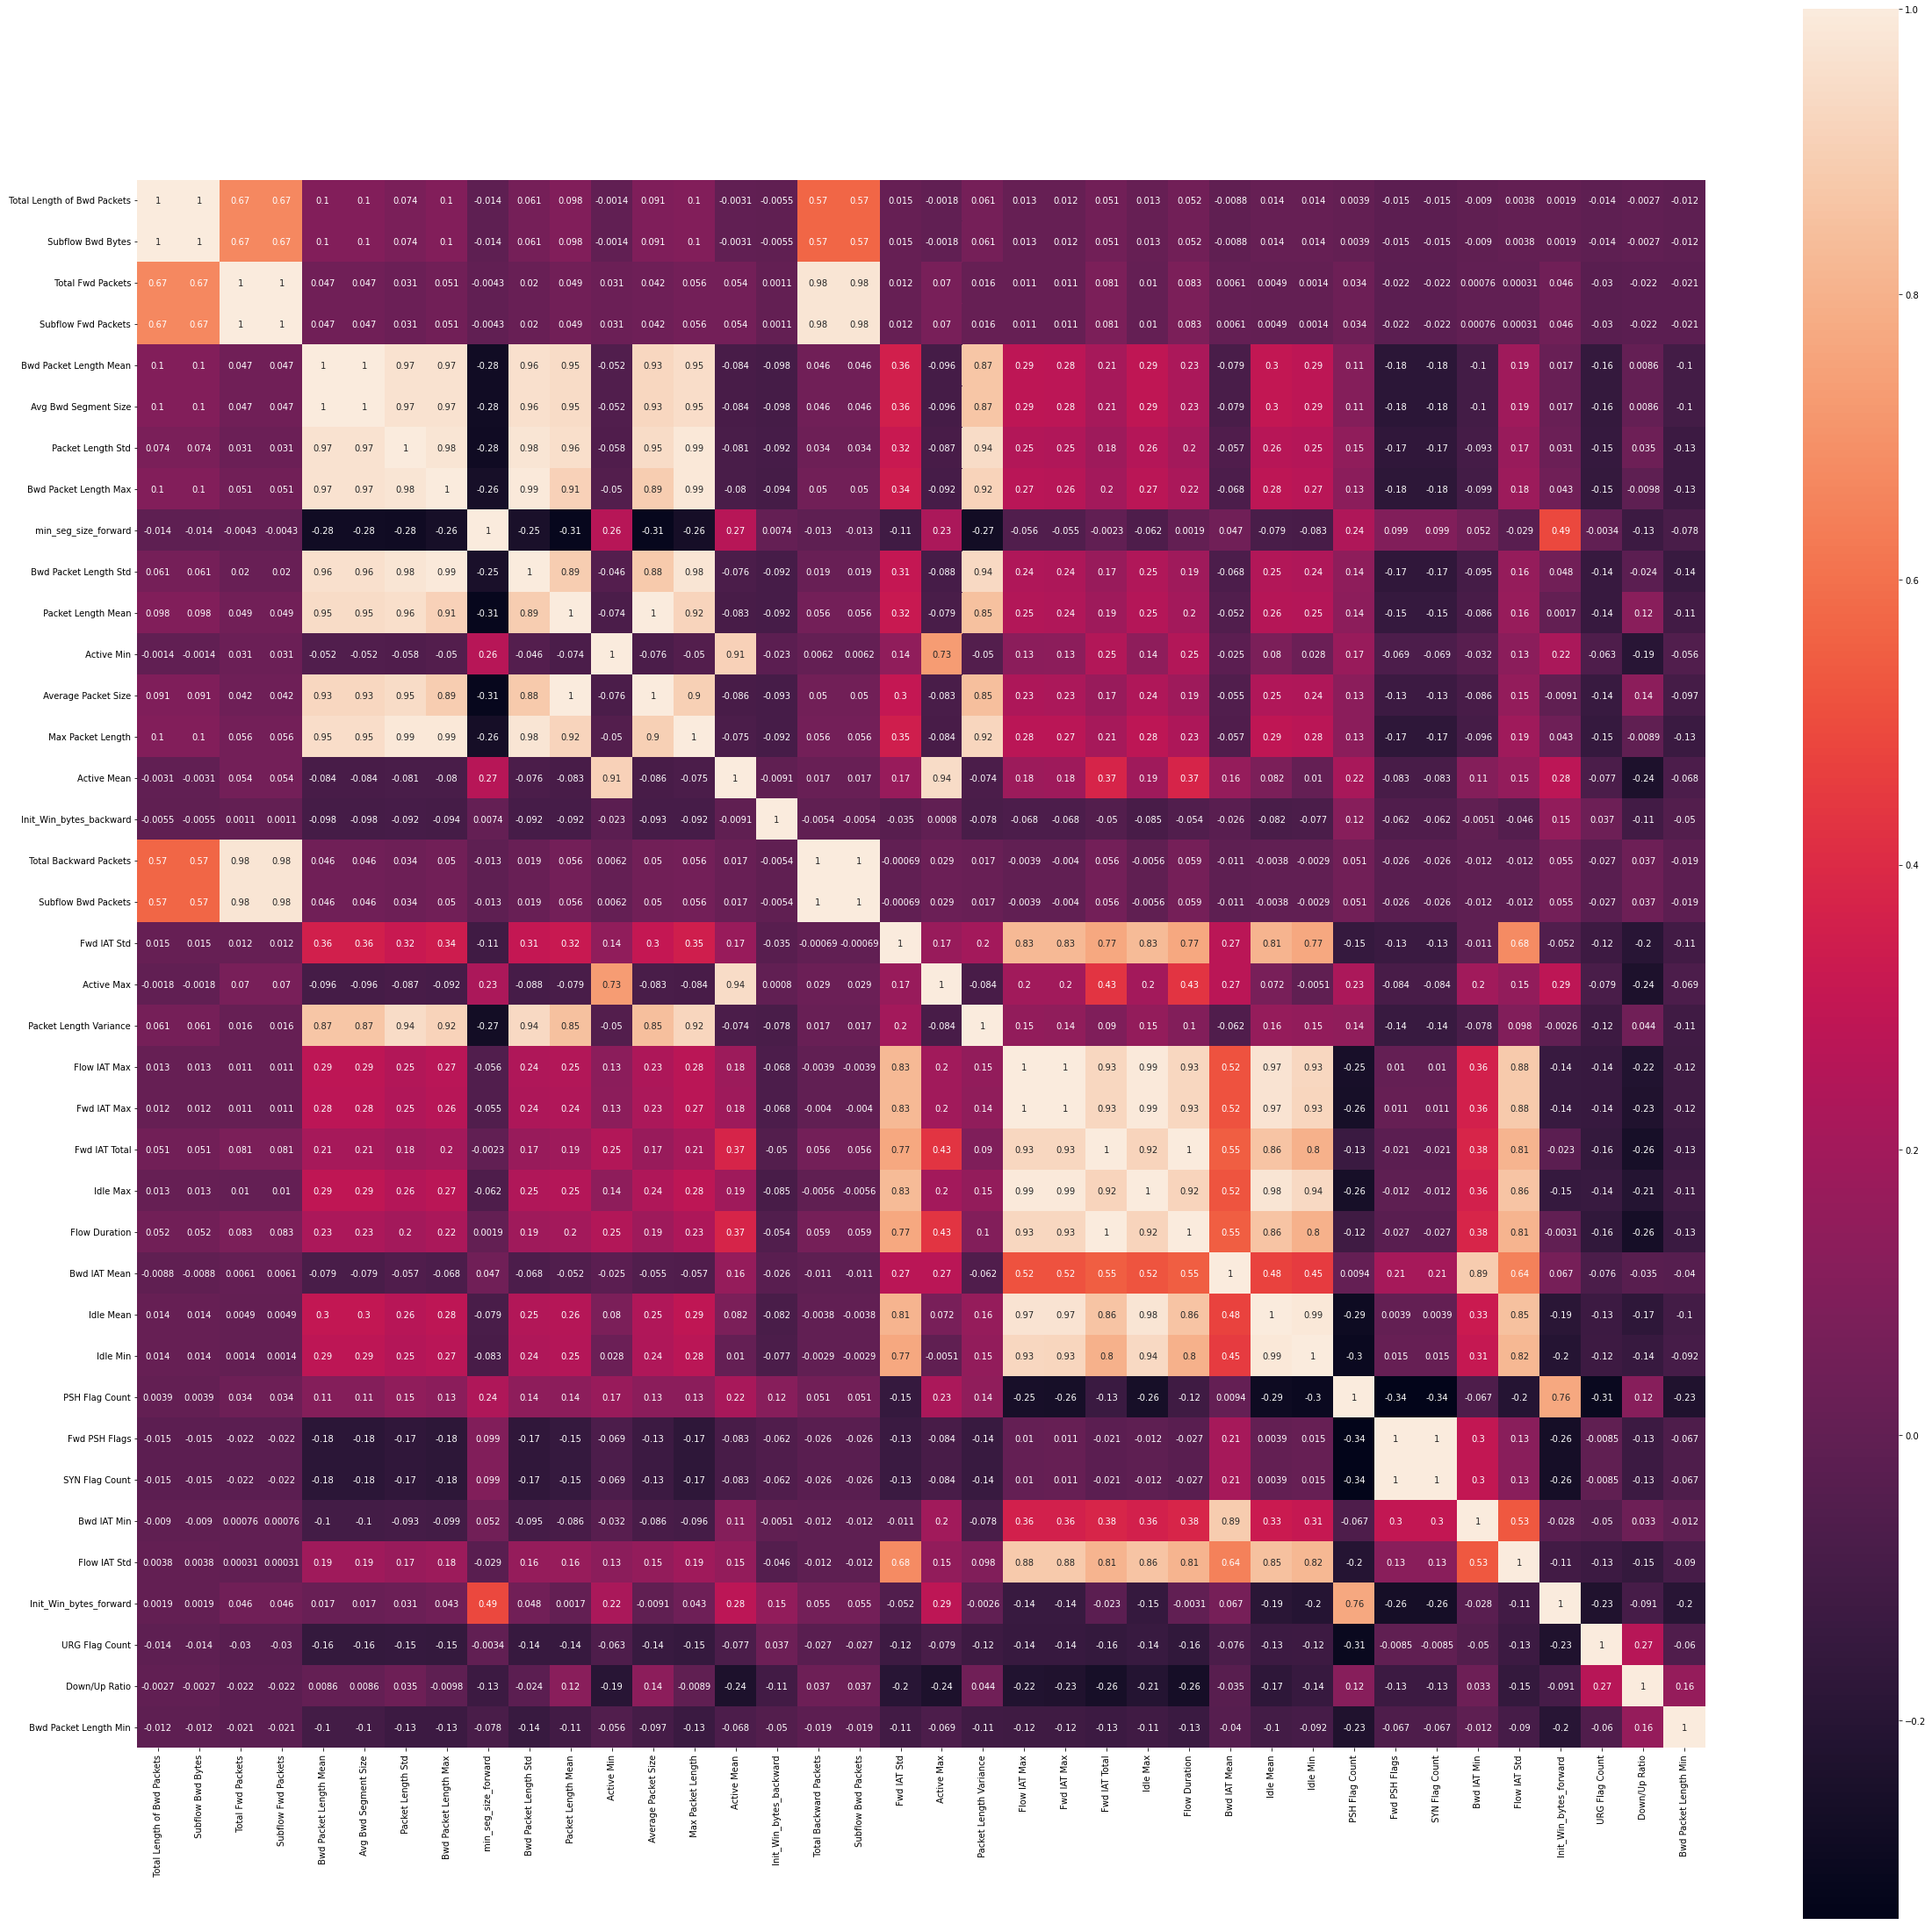

In [60]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, square=True)

Корреляция, статистический метод, который определяет, как одна переменная перемещается / изменяется по отношению к другой переменной. Когда у нас есть сильно коррелированные функции в наборе данных, это увеличивает дисперсию и ненадежность. Коррелеяция замечена с признаками:

* Total Length of Bwd Packets
* Subflow Bwd Bytes
* Fwd Header Length
* Fwd Header Length.1
* Bwd Header Length
* Total Fwd Packets
* Subflow Fwd Packets
* Bwd Packets Length Mean
* Avg Bwd Segment Size
* Packet Length Std
* Bwd Packet Length Max
* Bwd Packet Length Std
* Packet Length Mean
* Flow IAT Max
* Fwd IAT Max
* Fwd IAT Total
* Idle Max
* Flow Duration
* Idle Mean
* Idle Min

Отбросим данные поля для повышения качества датасета
                

In [61]:
feature.drop([' Total Length of Bwd Packets'],axis=1,inplace=True)
feature.drop([' Subflow Bwd Bytes'],axis=1,inplace=True)

KeyError: ignored

In [63]:
feature.drop([' Total Fwd Packets'],axis=1,inplace=True)


In [65]:
feature.drop(['Subflow Fwd Packets'],axis=1,inplace=True)

In [68]:
feature.drop([' Bwd Packet Length Mean'],axis=1,inplace=True)

In [69]:
feature.drop([' Avg Bwd Segment Size'],axis=1,inplace=True)

In [70]:
feature.drop([' Packet Length Std'],axis=1,inplace=True)

In [72]:
feature.drop(['Bwd Packet Length Max'],axis=1,inplace=True)

In [74]:
feature.drop([' Bwd Packet Length Std'],axis=1,inplace=True)

In [75]:
feature.drop([' Packet Length Mean'],axis=1,inplace=True)

In [76]:
feature.drop([' Average Packet Size'],axis=1,inplace=True)

In [77]:
feature.drop([' Max Packet Length'],axis=1,inplace=True)

In [78]:
feature.drop([' Flow IAT Max'],axis=1,inplace=True)

In [79]:
feature.drop([' Fwd IAT Max'],axis=1,inplace=True)

In [81]:
feature.drop(['Fwd IAT Total'],axis=1,inplace=True)

In [83]:
feature.drop([' Idle Max'],axis=1,inplace=True)

In [84]:
feature.drop([' Flow Duration'],axis=1,inplace=True)

In [86]:
feature.drop(['Idle Mean'],axis=1,inplace=True)

In [88]:
feature.drop([' Idle Min'],axis=1,inplace=True)

Проверим тепловую карту опять на предмет коррелирующих признаков

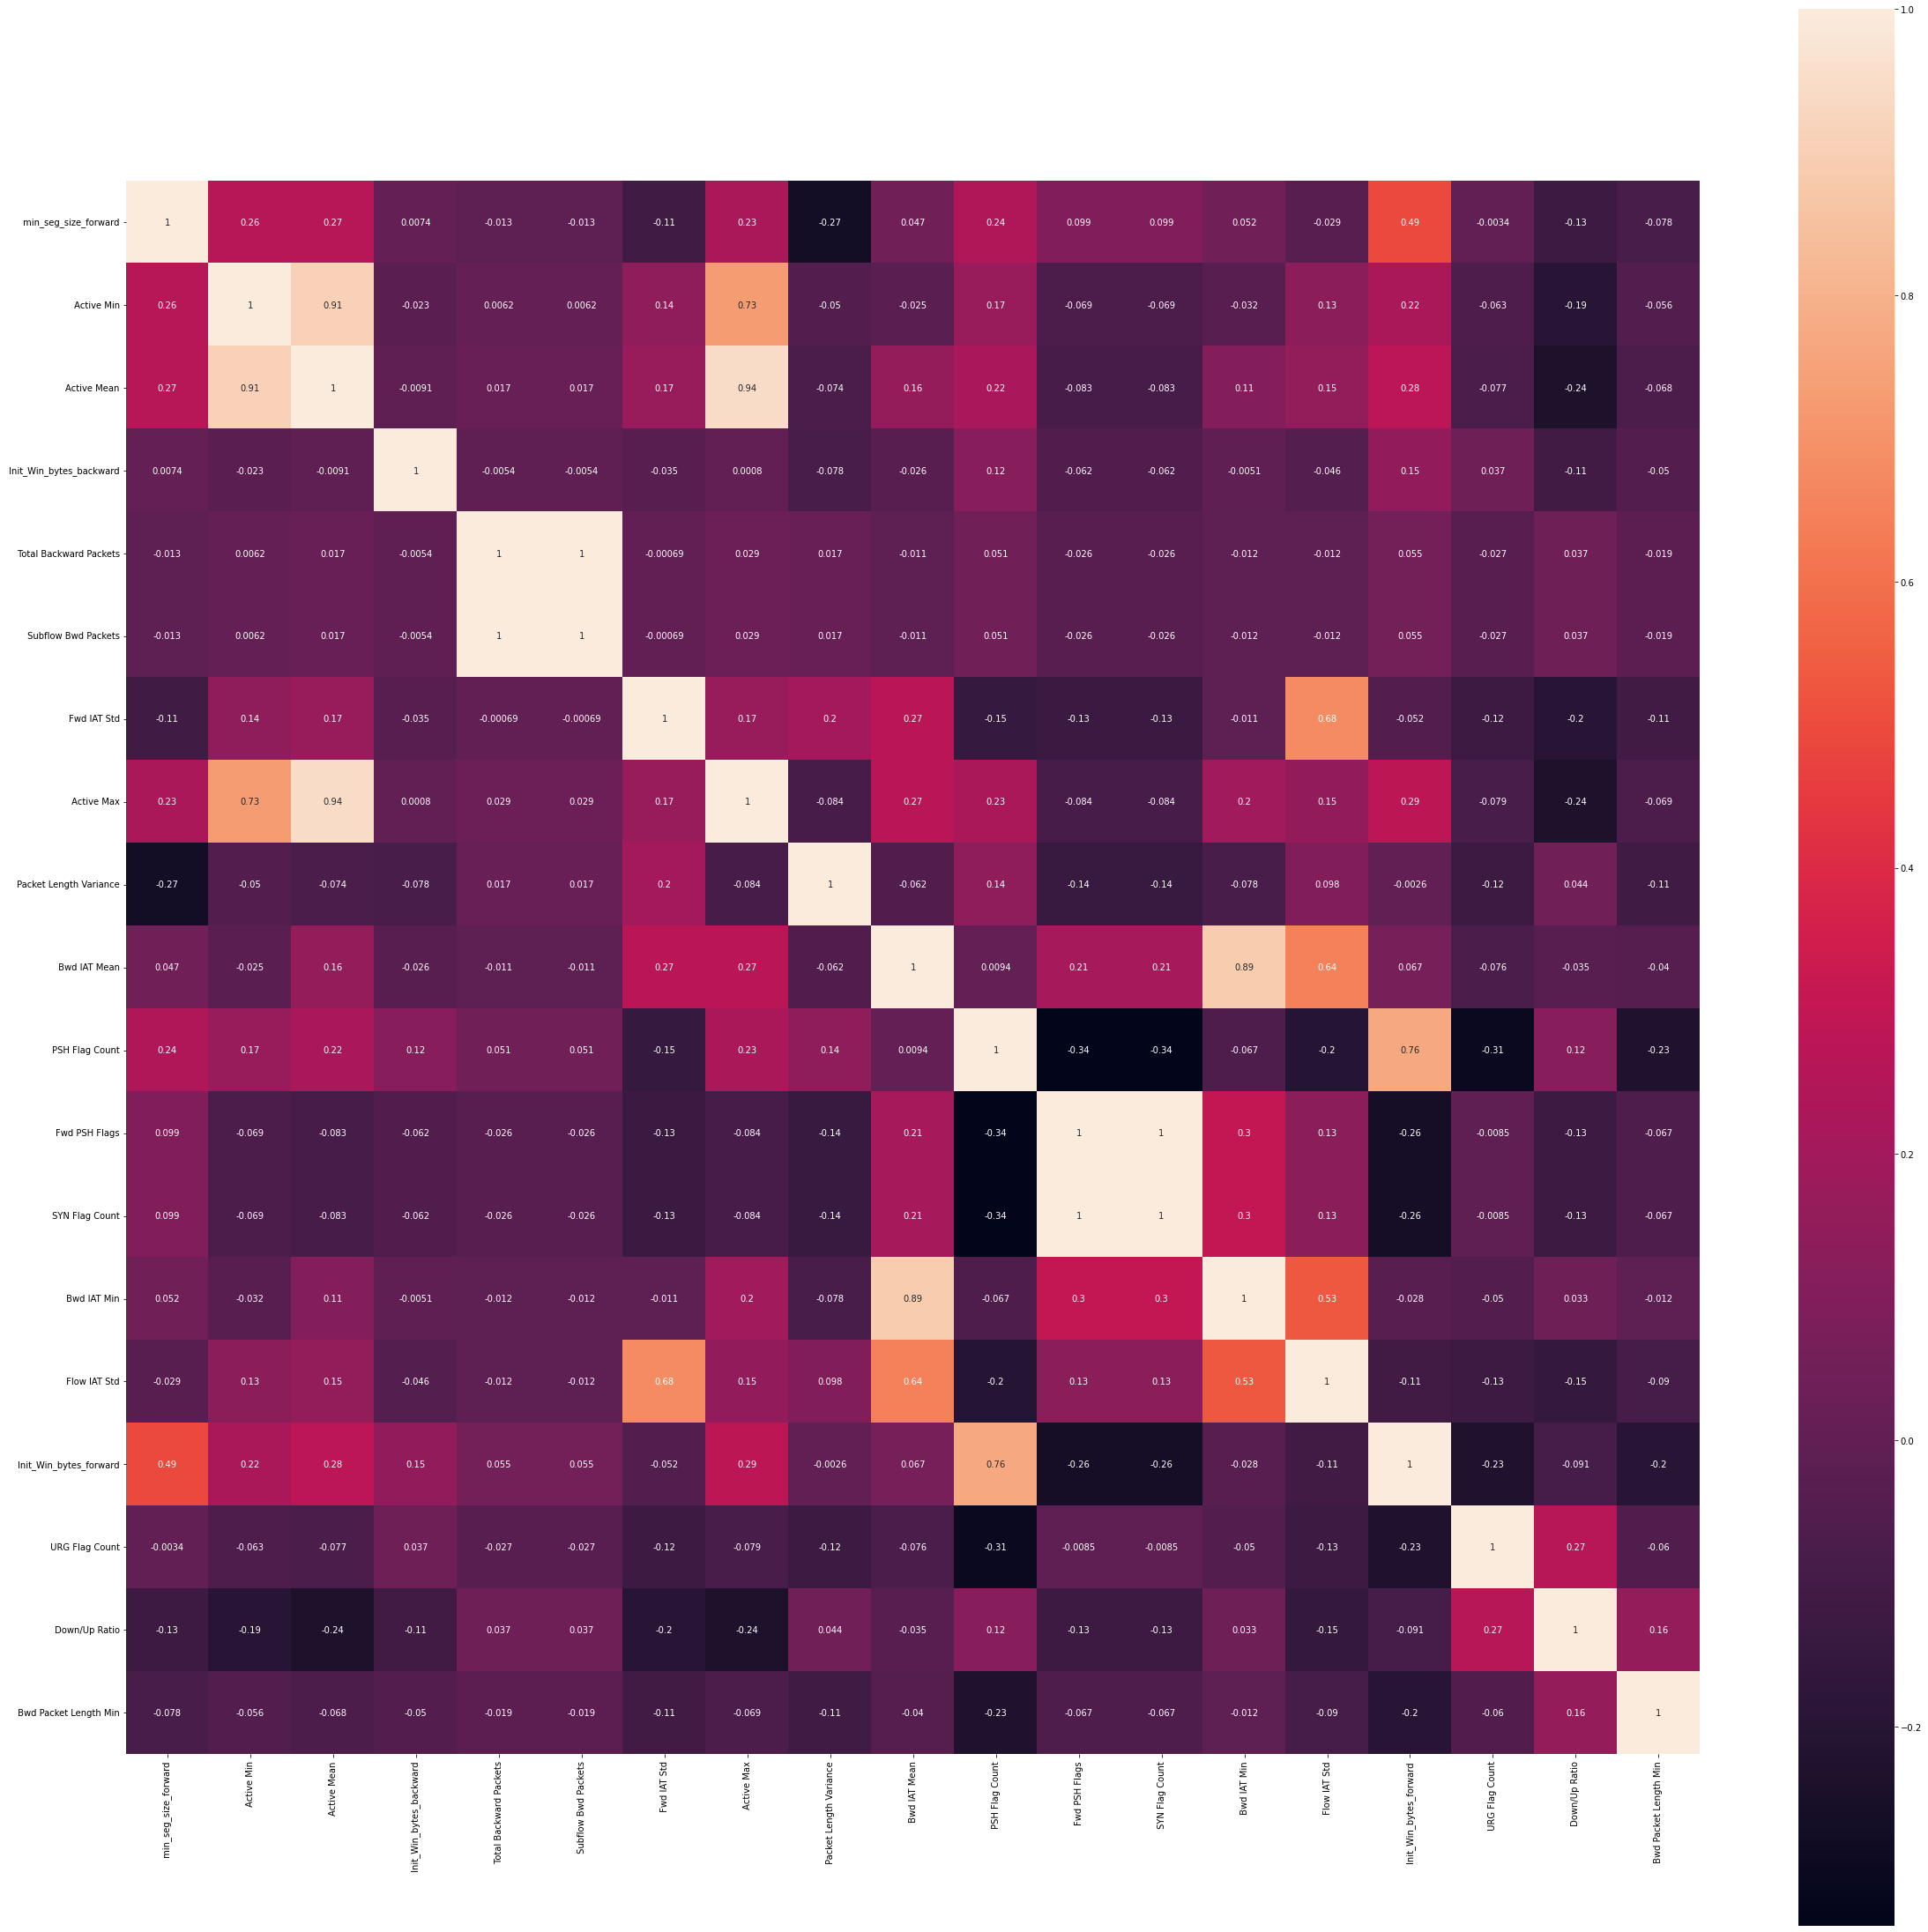

In [90]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, square=True)

Подсчитаем оставшееся количество пакетов после удаления признаков

In [91]:
feature[' Label'].value_counts()

BENIGN                        13639
DoS GoldenEye                 10293
DDoS                          10242
PortScan                       9536
DoS Hulk                       9243
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
Heartbleed                       11
Name:  Label, dtype: int64

In [92]:
attackType = feature[' Label'].unique()
feature[' Label'] = feature[' Label'].astype('category')
feature[' Label'] = feature[' Label'].astype("category").cat.codes

In [93]:
print (attackType)
print (feature[' Label'].value_counts())

['Bot' 'Infiltration' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS GoldenEye' 'Heartbleed' 'BENIGN' 'DDoS'
 'PortScan' 'DoS Hulk']
0     13639
3     10293
2     10242
10     9536
4      9243
7      7938
11     5897
6      5796
5      5499
1      1966
12     1507
14      652
9        36
13       21
8        11
Name:  Label, dtype: int64


In [94]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82276 entries, 24072 to 9242
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    min_seg_size_forward     82276 non-null  int16  
 1    Active Min               82276 non-null  int32  
 2   Active Mean               82276 non-null  float32
 3    Init_Win_bytes_backward  82276 non-null  int32  
 4    Total Backward Packets   82276 non-null  int32  
 5    Subflow Bwd Packets      82276 non-null  int32  
 6    Fwd IAT Std              82276 non-null  float32
 7    Active Max               82276 non-null  int32  
 8    Packet Length Variance   82276 non-null  float32
 9    Bwd IAT Mean             82276 non-null  float32
 10   PSH Flag Count           82276 non-null  int8   
 11  Fwd PSH Flags             82276 non-null  int8   
 12   SYN Flag Count           82276 non-null  int8   
 13   Bwd IAT Min              82276 non-null  int32  
 14   Fl

In [95]:
feature0 = feature[feature[' Label'] == 0]
feature0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13639 entries, 0 to 13638
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    min_seg_size_forward     13639 non-null  int16  
 1    Active Min               13639 non-null  int32  
 2   Active Mean               13639 non-null  float32
 3    Init_Win_bytes_backward  13639 non-null  int32  
 4    Total Backward Packets   13639 non-null  int32  
 5    Subflow Bwd Packets      13639 non-null  int32  
 6    Fwd IAT Std              13639 non-null  float32
 7    Active Max               13639 non-null  int32  
 8    Packet Length Variance   13639 non-null  float32
 9    Bwd IAT Mean             13639 non-null  float32
 10   PSH Flag Count           13639 non-null  int8   
 11  Fwd PSH Flags             13639 non-null  int8   
 12   SYN Flag Count           13639 non-null  int8   
 13   Bwd IAT Min              13639 non-null  int32  
 14   Flow 

In [96]:
y = feature[' Label']
X = feature.drop([' Label'],axis=1)

<h2>Сэмплируем недостающее количество записей для балансировки датасета.</h2>

In [97]:
from imblearn.under_sampling import RandomUnderSampler

RandSamp = RandomUnderSampler('majority')
X_RandS, y_RandS = RandSamp.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [98]:
X_RandS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68648 entries, 0 to 68647
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    min_seg_size_forward     68648 non-null  int16  
 1    Active Min               68648 non-null  int32  
 2   Active Mean               68648 non-null  float32
 3    Init_Win_bytes_backward  68648 non-null  int32  
 4    Total Backward Packets   68648 non-null  int32  
 5    Subflow Bwd Packets      68648 non-null  int32  
 6    Fwd IAT Std              68648 non-null  float32
 7    Active Max               68648 non-null  int32  
 8    Packet Length Variance   68648 non-null  float32
 9    Bwd IAT Mean             68648 non-null  float32
 10   PSH Flag Count           68648 non-null  int8   
 11  Fwd PSH Flags             68648 non-null  int8   
 12   SYN Flag Count           68648 non-null  int8   
 13   Bwd IAT Min              68648 non-null  int32  
 14   Flow 

In [99]:
y_RandS.value_counts()

3     10293
2     10242
10     9536
4      9243
7      7938
11     5897
6      5796
5      5499
1      1966
12     1507
14      652
9        36
13       21
8        11
0        11
Name:  Label, dtype: int64

In [100]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek('not majority' ,n_jobs=-1)
X_smt, y_smt = smt.fit_resample(X_RandS, y_RandS)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [103]:
y_smt.value_counts()

8     10293
7     10293
11    10290
13    10289
9     10288
3     10288
0     10288
10    10287
1     10284
6     10264
5     10261
4     10234
2     10226
12     8930
14     8928
Name:  Label, dtype: int64

<h2> Сохраним и разделим датасет на тестовую и тренировочную часть </h2>

In [104]:
X_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt.csv')
y_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/y_smt.csv')

In [ ]:
y_smt.value_counts()

Разделение датасета на тестовый и тренировочный

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X,train_y,test_y=train_test_split(X_smt,y_smt,test_size=0.3, random_state=10)

Объявление переменных

In [ ]:
path = '/content/drive/MyDrive/CICIDS2017/data_nn'
data = []
target = []

Чтение датасета.

In [ ]:
for name in os.listdir(path):
    file = pd.read_csv(os.path.join(path, name))
    print ('Types of marks in', name, ":", file[' Label'].unique())
    for n, i in file.iterrows():
        a = []
        for j in i[:-1]:
          a.append(j)
        data.append(a) 
        target.append(0 if i[-1] == 'BENIGN' else 1) 
del file


Types of marks in Wednesday-workingHours.pcap_ISCX.csv : ['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']
Types of marks in Tuesday-WorkingHours.pcap_ISCX.csv : ['BENIGN' 'FTP-Patator' 'SSH-Patator']
Types of marks in Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv : ['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
Types of marks in Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv : ['BENIGN' 'Infiltration']
Types of marks in Monday-WorkingHours.pcap_ISCX.csv : ['BENIGN']
Types of marks in Friday-WorkingHours-Morning.pcap_ISCX.csv : ['BENIGN' 'Bot']
Types of marks in Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv : ['BENIGN' 'PortScan']
Types of marks in Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv : ['BENIGN' 'DDoS']


Обработка данных

In [ ]:
data = np.array(data)
target = np.array(target)
print(data.shape, target.shape)


(2830743, 78) (2830743,)


Подготовка данных для нормализации

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.nan_to_num(data).astype(float))
data = scaler.transform(np.nan_to_num(data).astype(float))
data = data.reshape(data.shape[0], 78, 1)
 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
datax = data.reshape(data.shape[0], 78)
ax = sns.heatmap(datax) 

Сохранение нормализатора

In [ ]:
pickle.dump(scaler, open('/content/drive/MyDrive/CICIDS2017/devtest/scaler.pkl', 'wb'))

Моделирование нейросети

In [ ]:
lstm = Sequential()
lstm.add(Input((78, 1)))
lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
for i in range(3):
  lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
lstm.add(Flatten())
lstm.add(Dense(2,activation = 'softmax'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Тренировка нейросети

In [ ]:
lstm.fit(data, to_categorical(target), epochs=2, batch_size=256, verbose=1)

lstm.save('/content/drive/MyDrive/CICIDS2017/devtest/lstm.h5')

Получение данных от нейросети

In [ ]:
y_pred1 = lstm.predict(data, batch_size=1024)
y_pred = np.argmax(y_pred1, axis=1)

Вычисление метрик и количества пакетов с атакой и без

In [ ]:
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(target, y_pred))
print('Confussion Matrix', confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Alghorythm marked', count_list[1], 'as attack and', count_list[1], "packets as benign")

Чтение датасета для второй нейросети. KNN

In [ ]:
data = []
target = []
last = []
for name in os.listdir(path):
    file = pd.read_csv(os.path.join(path, name))
    for n, i in file.iterrows():
        if not i[-1] in last:
            last.append(i[-1])
        if last.index(i[-1]) != 0:
          a = []
          for j in i[:-1]:
              a.append(j)
          data.append(a)
          target.append(last.index(i[-1])-1)
del file
del last[0]

Обработка

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 78)
print(data.shape, target.shape)

Загрузка нормализатора

In [ ]:
scaler = pickle.load(open('/content/drive/MyDrive/scaler.pkl', 'rb'))

Нормализация данных для второй нейросети

In [ ]:
data = scaler.transform(np.nan_to_num(data).astype(float))

Моделирование второй нейросети

In [ ]:
knn = Sequential()
knn.add(InputLayer((78,)))
knn.add(BatchNormalization())
knn.add(Dense(128, activation='relu'))
knn.add(Dense(128, activation='relu'))
knn.add(Dense(14, activation='softmax'))
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
knn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

Тренировка второй нейросети

In [ ]:
knn.fit(data.astype(float), target, epochs=10, batch_size=256, verbose=1)

knn.save('/content/drive/MyDrive/knn.h5')

Получение данных со второй нейросети

In [ ]:
y_pred1 = knn.predict(data)
y_pred = np.argmax(y_pred1, axis=1)

Вычисление метрик и количество классов

In [ ]:
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(to_categorical(target), np.nan_to_num(y_pred1), multi_class='ovr'))
print('матрица неточностей', confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Классы:')
for i in count_list:
  print(last[i], count_list[i])

-

-

-

Здесь начинается проверка нейросети

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

Загрузка заранее обученной нейросети

In [ ]:
lstm = load_model('/content/drive/MyDrive/lstm.h5')
knn = load_model('/content/drive/MyDrive/knn.h5')

Загрузка данных для тестирования нейросети

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/net/Tuesday-WorkingHours.pcap_ISCX.csv')
data = []
target = []

for n, i in file.iterrows():
        a = []
        for j in i[:-1]:
          a.append(j)
        data.append(a)
        target.append(last.index(i[-1]))

Обработка данных

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 78, 1)
print(data.shape, target.shape)

Проверка нейросети

In [ ]:
model.evaluate(data, target)

Предсказание нейросети

In [ ]:
pred = model.predict(data)

Определение класса предсказанния нейросети

In [ ]:
print(last[np.argmax(pred[5])])